In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# import tensorflow.python.util.deprecation as deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

In [2]:
with open('data_batch_1', 'rb') as f:
    batch_1 = pickle.load(f, encoding='bytes')

In [3]:
images = np.zeros((10000, 32, 32, 3), dtype='uint8')

for idx, img in enumerate(batch_1[b'data']):
    images[idx, :, :, 0] = img[:1024].reshape((32, 32)) # Red
    images[idx, :, :, 1] = img[1024:2048].reshape((32, 32)) # Green
    images[idx, :, :, 2] = img[2048:].reshape((32, 32)) # Blue

In [4]:
images = images / 255.

In [5]:
input_layer = Input(shape=(32, 32, 3,))

In [6]:
hidden_encoding = Conv2D(
    32, # Number of filters in the weight matrix
    (3, 3), # Shape of the weight matrix
    activation='relu',
    padding='same', # Retaining dimensions between input and output
)(input_layer)

In [7]:
encoded = MaxPooling2D((2, 2))(hidden_encoding)

In [8]:
hidden_decoding = Conv2D(
    32, # Number of filters in the weight matrix
    (3, 3), # Shape of the weight matrix
    activation='relu',
    padding='same', # Retaining dimensions between input and output
)(encoded)

In [9]:
upsample_decoding = UpSampling2D((2, 2))(hidden_decoding)

In [10]:
decoded = Conv2D(
    3, # Number of filters in the weight matrix
    (3, 3), # Shape of the weight matrix
    activation='sigmoid',
    padding='same', # Retaining dimensions between input and output
)(upsample_decoding)

In [11]:
autoencoder = Model(input_layer, decoded)

In [12]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 3)         867       
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________

In [13]:
autoencoder.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [14]:
autoencoder.fit(images, images, epochs=20)

Train on 10000 samples
Epoch 1/2
10000/10000 [==============================] - 38s 4ms/sample - loss: 0.7076
Epoch 2/2
10000/10000 [==============================] - 34s 3ms/sample - loss: 0.7032


In [15]:
encoder_output = Model(input_layer, encoded).predict(images[:5])

In [16]:
encoder_output = encoder_output.reshape((-1, 256, 32))

In [17]:
decoder_output = autoencoder.predict(images[:5])

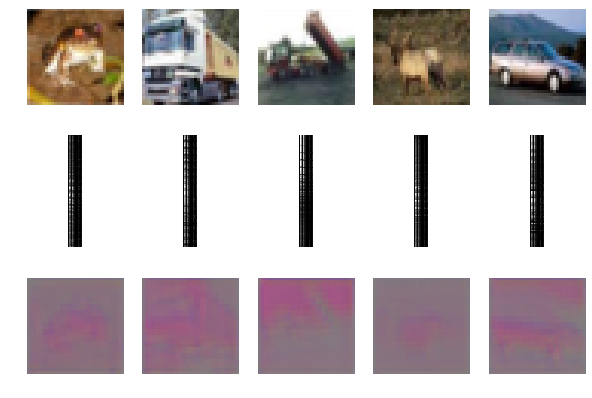

In [18]:
plt.figure(figsize=(10, 7))
for i in range(5):
    # Plot original images
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    
    # Plot encoder output
    plt.subplot(3, 5, i + 6)
    plt.imshow(encoder_output[i], cmap='gray')
    plt.axis('off')   
    
    # Plot decoder output
    plt.subplot(3, 5, i + 11)
    plt.imshow(decoder_output[i])
    plt.axis('off')        

In [19]:
#  Unit Test

In [20]:
import unittest
class TestEncodeDecode(unittest.TestCase):   
    
    def test_batch_1(self):
        self.assertEqual(len(batch_1),4)
        
    def test_images(self):
        self.assertEqual(len(images),10000)
        
    def test_input_layer_shape(self):
        self.assertListEqual(list(input_layer.shape),[None, 32, 32, 3])
        
    def test_hidden_encoding_shape(self):
        self.assertListEqual(list(hidden_encoding.shape),[None, 32, 32, 32])
        
    def test_encoded(self):
        self.assertListEqual(list(encoded.shape),[None, 16, 16, 32])
        
    def test_hidden_decoding_shape(self):
        self.assertListEqual(list(hidden_decoding.shape),[None, 16, 16, 32])
        
    def test_upsample_decoding_shape(self):
        self.assertListEqual(list(upsample_decoding.shape),[None, 32, 32, 32])
        
        
    def test_decoded(self):
        self.assertListEqual(list(decoded.shape),[None, 32, 32, 3])
        
        
    def test_encoder_output_len(self):
        self.assertEqual(len(encoder_output),5)
        
    def test_decoder_output_len(self):
        self.assertEqual(len(decoder_output),5)
        
         

In [21]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestEncodeDecode)
unittest.TextTestRunner(verbosity=2).run(suite)

test_batch_1 (__main__.TestEncodeDecode) ... ok
test_decoded (__main__.TestEncodeDecode) ... ok
test_decoder_output_len (__main__.TestEncodeDecode) ... ok
test_encoded (__main__.TestEncodeDecode) ... ok
test_encoder_output_len (__main__.TestEncodeDecode) ... ok
test_hidden_decoding_shape (__main__.TestEncodeDecode) ... ok
test_hidden_encoding_shape (__main__.TestEncodeDecode) ... ok
test_images (__main__.TestEncodeDecode) ... ok
test_input_layer_shape (__main__.TestEncodeDecode) ... ok
test_upsample_decoding_shape (__main__.TestEncodeDecode) ... ok

----------------------------------------------------------------------
Ran 10 tests in 0.018s

OK


<unittest.runner.TextTestResult run=10 errors=0 failures=0>